In [5]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_decay import *

sim_name = f"no_gravity_decay"
#! marias files are inside the Data/decay folder
decay_dir = f"Data/decay"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

z_int_steps = jnp.load(f"{sim_folder}/z_int_steps.npy")
s_int_steps = jnp.load(f"{sim_folder}/s_int_steps.npy")

# note: We must have realistic neutrino masses
m_light, m_mid, m_heavy = Physics.neutrino_masses(
    m_lightest=0.05*Params.eV, ordering="NO", args=Params())
print(m_light, m_mid, m_heavy)

def find_nearest(array, value):
    idx = jnp.argmin(jnp.abs(array - value))
    return idx, array[idx]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.05 0.05073657457889723 0.07080960386840193


## Pre-sim arrays analysis

In [6]:
Gamma_str ='2T'

angle_momentum_decay = jnp.load(
    f'{sim_folder}/allowed_decay_angles_and_momenta.npy') 
decayed_neutrinos_z = jnp.load(
    f'{sim_folder}/decayed_neutrinos_z_{Gamma_str}.npy')
decayed_neutrinos_index_z = jnp.load(
    f'{sim_folder}/decayed_neutrinos_index_z_{Gamma_str}.npy', allow_pickle=True)

z_array = jnp.load(
    f'{sim_folder}/z_int_steps.npy')
neutrino_momenta = jnp.load(
    f'{sim_folder}/neutrino_momenta.npy')

common_args = (
    angle_momentum_decay, decayed_neutrinos_z, z_array, neutrino_momenta,)

ic(angle_momentum_decay.shape)
ic(decayed_neutrinos_z.shape)
ic(decayed_neutrinos_index_z.shape)
ic(z_array.shape)
ic(neutrino_momenta.shape)
print("END")

ic| angle_momentum_decay.shape: (1000, 1800, 2)
ic| decayed_neutrinos_z.shape: (99, 768000)
ic| decayed_neutrinos_index_z.shape: (99,)
ic| z_array.shape: (100,)
ic| neutrino_momenta.shape: (1000,)


END


## Testing functionality inside simulation script

### jax.lax.cond with decay_tracker

In [2]:
# If neutrino has decayed: Assign new velocity
def true_func(v_parent, decay_tracker):
    decay_tracker = decay_tracker.at[:].set(1)
    return v_parent, decay_tracker

# If neutrino has not decayed: Keep current velocity
def false_func(v_in, decay_tracker):
    return v_in, decay_tracker

# Example input values
pre_nu_number = jnp.array([1,1,0])
now_nu_number = jnp.array([1,0,0])
decay_tracker = jnp.zeros(3)
v_parent = jnp.array([1.0, 0.0, 0.0])
v_in = jnp.array([0.5, 0.5, 0.5])

for pre, now in zip(pre_nu_number, now_nu_number):

    # Get new/current velocity depending on decay condition being True/False
    v_out, decay_tracker = jax.lax.cond(
        (now == 0) & (pre == 1) & jnp.all(decay_tracker == 0),
        lambda _: true_func(v_parent, decay_tracker),
        lambda _: false_func(v_in, decay_tracker),
        operand=None
    )

    v_in = v_out

    print("v_out:", v_out)
    print("updated_decay_tracker:", decay_tracker)

v_out: [0.5 0.5 0.5]
updated_decay_tracker: [0. 0. 0.]
v_out: [1. 0. 0.]
updated_decay_tracker: [1. 1. 1.]
v_out: [1. 0. 0.]
updated_decay_tracker: [1. 1. 1.]


In [21]:
def test(v_parent, decay_tracker):
    decay_tracker = decay_tracker.at[:].set(v_parent)
    return v_parent, decay_tracker

decay_tracker = jnp.zeros(3)
v_parent = jnp.arange(3)
arrt = test(v_parent, decay_tracker)
print(arrt)

(Array([0, 1, 2], dtype=int64), Array([0., 1., 2.], dtype=float64))


### Masking and valid indices arrays

In [16]:
decay_angles = angle_momentum_decay[..., 0]
parent_momenta = angle_momentum_decay[..., 1]
print(decay_angles.shape, parent_momenta.shape)

p_index = 0
s_key = jnp.array([0, 0], dtype=jnp.uint32)

valid_mask = parent_momenta[p_index] > 0
valid_indices = jnp.arange(parent_momenta.shape[-1])
valid_indices = jnp.where(valid_mask, valid_indices, -1)
valid_indices = valid_indices[valid_indices != -1]
print(valid_indices.shape)

random_idx = jax.random.choice(s_key, valid_indices)
decay_theta = decay_angles[p_index, random_idx]
p_parent = parent_momenta[p_index, random_idx]

(1000, 1800) (1000, 1800)
(900,)


In [18]:
def find_first_negative_indices(array):
    # Create a mask where the condition (array < 0) is True
    negative_mask = array < 0

    # Find the index of the first negative value in each row
    first_negative_indices = jnp.argmax(negative_mask, axis=-1)
    
    # If no negative values, set index to the last element in the row
    row_has_negative = jnp.any(negative_mask, axis=-1)
    first_negative_indices = jnp.where(row_has_negative, first_negative_indices, array.shape[1] - 1)
    
    return first_negative_indices

# Example usage
parent_momenta = jnp.array([[1.0, 0.5, -0.2, -0.5],
                            [2.0, 1.5, 1.0, 0.5],
                            [3.0, -1.0, -2.0, -3.0]])

indices = find_first_negative_indices(parent_momenta)
print(indices)

[2 3 1]


## Parent number density functions

(1000, 1000)
For Gamma=0.1 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.45e-03 (2.45e-03)

(1000, 1000)
For Gamma=0.5 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 7.59e+00 (7.59e+00)

(1000, 1000)
For Gamma=1.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.07e+01 (2.07e+01)

(1000, 1000)
For Gamma=2.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 3.43e+01 (3.43e+01)



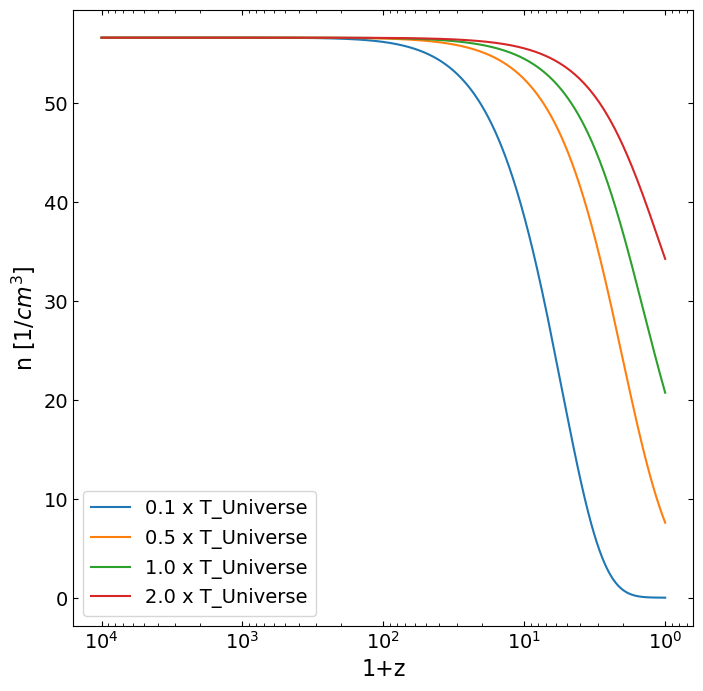

In [ ]:
age_multipliers = [
    0.1, 
    0.5, 
    1., 
    2.
]

p_range = jnp.geomspace(0.01, 400, 1000)*Params.T_CNB
z_0, z_dec = 0., 10_000.
z_range = Utils.make_logz_arr(z_0, z_dec, 1000)

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    ### New functions ###
    redshifted_p = p_range[:, None]*(1+z_range)

    n3_raw, *_ = Decay.n3_p_range(
        p=redshifted_p, z=z_range, 
        Gamma=Gamma_val, m_h=m_heavy, args=Params())
    print(n3_raw.shape)
    n3_redshifts = trap(n3_raw*redshifted_p, x=jnp.log(redshifted_p), axis=0)

    # Print & plot results.
    cm3_unit = 1/Params.cm**3
    print(f"For Gamma={age_mult} x T_Universe, parent nr. density:")
    print(f"z_dec: {jnp.max(n3_redshifts)/cm3_unit:.2f} ({n3_redshifts[-1]/cm3_unit:.2f})")
    print(f"z_0: {jnp.min(n3_redshifts)/cm3_unit:.2e} ({n3_redshifts[0]/cm3_unit:.2e})\n")
    
    ax.semilogx(
        1+z_range, n3_redshifts/cm3_unit,
        label=f"{age_mult} x T_Universe")
    ax.set_xlabel('1+z')
    ax.set_ylabel(r'n [$1/cm^3$]')

# ax.set_xlim(0,4)
ax.invert_xaxis()
plt.legend()
plt.show()

## Inverse sampling

In [ ]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)


histogram_data_l = []
for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    occurences_redshifts = Decay.montecarlo(
        z_range, p_range, m_heavy, simdata.nus_in_sim, Gamma_val, Params())
    # print(occurences_redshifts.shape)
    # print(occurences_redshifts.min(), occurences_redshifts.max())

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
        np.log10(np.min(1+occurences_redshifts)), 
        np.log10(np.max(1+occurences_redshifts)), 100)

    histogram_data, bin_edges, _ = ax.hist(
        occurences_redshifts, bins=log_bins, histtype="step",
        alpha=0.75, label=f"{age_mult} x T_Universe")
    # has shape bins-1

    print(histogram_data.shape, histogram_data.sum())
    histogram_data_l.append(histogram_data)

jnp.save(f"{save_dir}/histrogram_data.npy", jnp.array(histogram_data_l))

ax.set_xlabel("1+z")
ax.set_xscale("log")
ax.set_ylabel("# decays")
ax.invert_xaxis()
plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Generating pre-sim arrays

### Decay angles and momenta, as allowed by conservation laws

(10, 50, 2)
5 3.6032964613088203


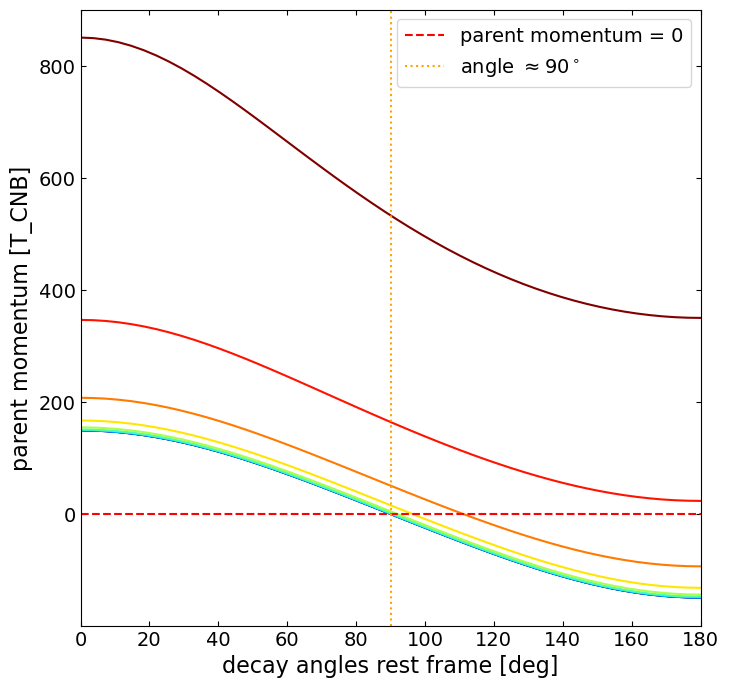

In [ ]:
from scipy.optimize import fsolve
# note: Using numpy routines for fsolve compatibility


def rest_frame_quantities(m_h, m_l, m_phi):

    # Energies of daughter particles
    E_l = (m_h**2 + m_l**2 - m_phi**2) / (2*m_h)
    E_phi = (m_h**2 - m_l**2 + m_phi**2) / (2*m_h)

    # Momenta of daughter particles
    p_l = np.sqrt((m_h**2+m_l**2-m_phi**2)**2 - 4*m_h**2*m_l**2) / (2*m_h)
    p_phi = np.sqrt((m_h**2-m_l**2+m_phi**2)**2 - 4*m_h**2*m_phi**2) / (2*m_h)

    return E_l, p_l, E_phi, p_phi


# Rest frame (suscript 0) kinematics are completely fixed by masses
E_l_0, p_l_0, E_phi_0, p_phi_0 = rest_frame_quantities(m_h=m_heavy, m_l=m_light, m_phi=0.0)
# print(f"CHECK 1: ", np.isclose(p_l_0 - p_phi_0, [0.0]))
# print(f"CHECK 2: ", np.isclose(E_l_0 + E_phi_0, [m_heavy]))


def lab_frame_parent_momenta(p_h, p_l_z_target, angle, m_h, E_l_0, p_l_0):

    # Decay angle between axis of boost and p_l_0, i.e. momentum of daughter in rest frame
    # note: angle is defined via unit circle, so 0 deg is antiparallel,
    # note: we subtract pi, s.t. 0 deg corresponds to "straight line decay" in same direction
    cos_theta_0 = np.cos(np.deg2rad(angle) - np.pi)

    # Energy, velocity and Lorentz factor
    E_h = np.sqrt(p_h**2 + m_h**2)
    v_h = p_h/E_h
    gamma = 1/np.sqrt(1 - v_h**2)

    # Daughter momentum in lab frame
    p_l_z = gamma*(p_l_0*cos_theta_0 + v_h*E_l_0)

    # Return output as needed for fsolve to solve for it to become zero
    return p_l_z - p_l_z_target



common_args = (m_heavy, E_l_0, p_l_0)
p_num = 10  # target: p_num of sim = 1000 (or higher if needed, but base is 1k)
p_l_z_target_range = np.geomspace(0.01, 400, p_num)*Params.T_CNB
a_min = 0
a_max = 180
a_num = 50  # target: 1800
angles = np.linspace(a_min, a_max, a_num)

p_h_sol = np.empty((len(p_l_z_target_range), len(angles), 2))
for i, p_l_z_target in enumerate(p_l_z_target_range):
    
    for j, angle in enumerate(angles):
        p_h_fsolve = fsolve(
            func=lab_frame_parent_momenta, x0=p_l_z_target,
            args=(p_l_z_target, angle, *common_args))[0]
        
        #! If negative, decay angle is impossible with target daughter momentum
        # if p_h_fsolve < 0.0:
        #     p_h_fsolve = np.nan

        p_h_sol[i,j,0] = angle
        p_h_sol[i,j,1] = p_h_fsolve

print(p_h_sol.shape)
np.save(f"{sim_folder}/allowed_decay_angles_and_momenta_notebook.npy", p_h_sol)

p_l_select = 3.15*Params.T_CNB
idx, val = find_nearest(p_l_z_target_range, p_l_select)
print(idx, val/Params.T_CNB)


fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

colors = plt.cm.jet(np.linspace(0, 1, p_num))
for c, p_h_set in enumerate(p_h_sol):

    ax.plot(p_h_set[..., 0], p_h_set[..., 1]/Params.T_CNB, color=colors[c])


ax.axhline(0.0, color="red", ls='dashed', label="parent momentum = 0")
ax.axvline(90.0, color="orange", ls="dotted", label=r"angle $\approx 90^\circ$")
ax.set_xlabel(f"decay angles rest frame [deg]")
ax.set_ylabel(f"parent momentum [T_CNB]")
ax.set_xlim(a_min, a_max)  # normal
# ax.set_xlim(85, 95) ; ax.set_ylim(-0.5, 0.5)  # zoom-in
plt.legend(loc="upper right")
plt.show(); plt.close()

### Decay redshifts

In [ ]:
def generate_decay_redshifts(histogram_data, gamma_str, neutrinos, save_dir):

    # Create an array representing individual neutrinos (all ones)
    neutrinos_array = np.ones(neutrinos)

    # Lists to store decayed information for each redshift step
    decayed_redshift = []
    neutrinos_decayed_index = []

    # Track remaining neutrino indices
    remaining_indices = np.arange(neutrinos)
    
    # Iterate over redshift steps
    for num_decayed in histogram_data:
        
        # Randomly select neutrinos to decay without replacement
        selected_indices = np.random.choice(
            remaining_indices, size=num_decayed, replace=False)
        
        # Remove selected indices from remaining indices
        remaining_indices = np.setdiff1d(remaining_indices, selected_indices)
                
        # Append and store values
        neutrinos_decayed_index.append(selected_indices)
        
        # Update neutrinos_array to reflect decayed neutrinos
        neutrinos_array[selected_indices] = 0
        decayed_redshift.append(np.copy(neutrinos_array))

    # One check if part of routine worked
    print(len(remaining_indices))
    print(neutrinos - histogram_data.sum())
    
    # Save the results
    neutrinos_decayed_index_array = np.array(neutrinos_decayed_index, dtype=object)
    np.save(f'{save_dir}/decayed_neutrinos_index_z_{gamma_str}.npy', neutrinos_decayed_index_array)
    np.save(f'{save_dir}/decayed_neutrinos_z_{gamma_str}.npy', decayed_redshift)

    print(np.array(decayed_redshift).shape)


gamma_strings = [
    "0.1T",
    "0.5T",
    "1T",
    "2T",
]

hist_data_arr = np.load(f"{save_dir}/histrogram_data.npy").astype(int)
for hist_data, g_str in zip(hist_data_arr, gamma_strings):

    generate_decay_redshifts(
        histogram_data=hist_data, gamma_str=g_str, 
        neutrinos=simdata.nus_in_sim, save_dir=save_dir)


10559
10559
(99, 768000)
326626
326626
(99, 768000)
500018
500018
(99, 768000)
619391
619391
(99, 768000)


## Testing and plotting

In [26]:
vec_pixel = jnp.load(f'{sim_folder}/vectors_halo1_test.npy')
vec_total = vec_pixel.reshape(-1,2,6)

tot_dens_d = Decay.number_densities_mass_range_decay(
    v_arr=vec_total[..., 3:], 
    m_arr=nu_m_picks, 
    pix_sr=4*Params.Pi,
    args=Params())


In [28]:
tot_dens_d

Array([56.59817452, 56.60912163, 56.60912146, 56.60912012, 56.60911649],      dtype=float64)